**PART ONE  PROJECT BASED**   

• DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene.

In [ ]:
#importing all the necessary libraries

import tensorflow
tensorflow.__version__

'2.7.0'

In [ ]:
# installing the segmentation model 

!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-dv04dxlf
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-dv04dxlf
  Running command git submodule update --init --recursive -q


In [ ]:
# importing all the necessary libraries

import numpy as np
import pandas as pd
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

import  matplotlib.pyplot as plt
import cv2
import random

from sklearn.model_selection import train_test_split,GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

In [ ]:
# mounting google drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# importing the dataset

np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle = True, **k)

data = np.load('/content/drive/MyDrive/Computer Vision/Week_7 Assignment/Part 1- Train data - images.npy')

In [ ]:
# checking the total number of images in the dataset

len(data)

409

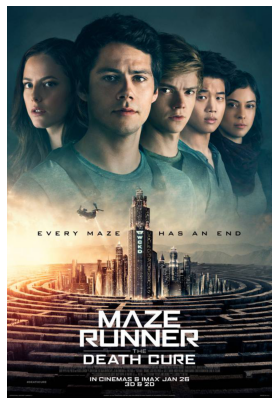

In [ ]:
# visualizing the 11th image in the dataset

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[11][0])
plt.show()

In [ ]:
# Setting the image height and width

IMAGE_SIZE = 128
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

In [ ]:
# creating features and labels using the dataset

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_AREA)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = (np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
print("The shape of the features is",X.shape)

The shape of the features is (409, 128, 128, 3)


In [ ]:
print("The shape of the masks is",masks.shape)

The shape of the masks is (409, 128, 128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


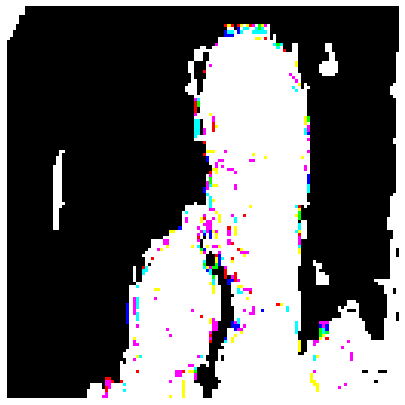

In [ ]:
# plotting a image and its mask

n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

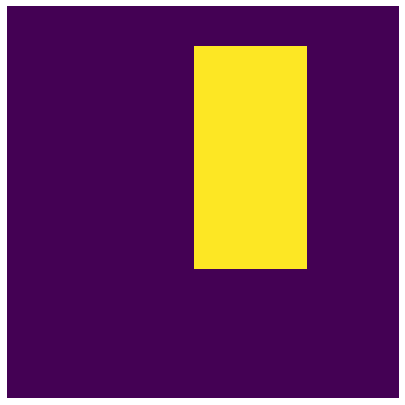

In [ ]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

In [ ]:
# splitting the data into train and vaidation

X_train, X_valid, y_train, y_valid = train_test_split(X, masks, test_size=0.25, random_state=0)

In [ ]:
print("The shape of X_train is", X_train.shape)

The shape of X_train is (306, 128, 128, 3)


In [ ]:
print("The shape of y_train is", y_train.shape)

The shape of y_train is (306, 128, 128)


In [ ]:
print("The shape of X_valid is", X_valid.shape)

The shape of X_valid is (103, 128, 128, 3)


In [ ]:
print("The shape of y_valid is", y_valid.shape)

The shape of y_valid is (103, 128, 128)


In [ ]:
# defining our own dice_coefficient and loss function

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return tensorflow.keras.backend.binary_crossentropy(y_true, y_pred) - tensorflow.math.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [ ]:
# importing the segmentation models

import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

from segmentation_models import Unet
from segmentation_models.utils import set_trainable 

# using resnet34 as backbone, encoder weights as imagenet and the decoder_block_type to transpose

model = Unet(backbone_name='resnet34',
             encoder_weights='imagenet', 
             encoder_freeze=True, 
             input_shape=(None, None, 3),
             decoder_block_type = 'transpose')

Segmentation Models: using `keras` framework.


In [ ]:
# compiling the model using the loss and the dice coefficient 

model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [ ]:
# Preprocessing the X_train and X_valid using the restnet34 backbone

from segmentation_models import get_preprocessing

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)

In [ ]:
# fitting the model on the training set with batch size of 8 and 100 epochs

model.fit(
    x=X_train,
    y=y_train,
    batch_size=8,   
    epochs=100,
    validation_data=(X_valid, y_valid)
    )

Epoch 1/100
39/39 [==============================] - 10s 108ms/step - loss: 1.3069 - dice_coefficient: 0.4115 - val_loss: 5.8119 - val_dice_coefficient: 0.2512
Epoch 2/100
39/39 [==============================] - 2s 61ms/step - loss: 0.7715 - dice_coefficient: 0.5908 - val_loss: 2.4202 - val_dice_coefficient: 0.3459
Epoch 3/100
39/39 [==============================] - 2s 63ms/step - loss: 0.6643 - dice_coefficient: 0.6407 - val_loss: 1.3943 - val_dice_coefficient: 0.4917
Epoch 4/100
39/39 [==============================] - 3s 65ms/step - loss: 0.6098 - dice_coefficient: 0.6666 - val_loss: 2.1891 - val_dice_coefficient: 0.4399
Epoch 5/100
39/39 [==============================] - 2s 59ms/step - loss: 0.5814 - dice_coefficient: 0.6801 - val_loss: 0.8763 - val_dice_coefficient: 0.5987
Epoch 6/100
39/39 [==============================] - 3s 67ms/step - loss: 0.5340 - dice_coefficient: 0.6979 - val_loss: 0.8082 - val_dice_coefficient: 0.6463
Epoch 7/100
39/39 [==============================]

In [ ]:
# evaluating the model on the validation set

model.evaluate(X_valid, y_valid, verbose = 1)

4/4 [==============================] - 0s 26ms/step - loss: 1.1365 - dice_coefficient: 0.6376


[1.1365264654159546, 0.6376091241836548]

In [ ]:
# loading the test image from google drive

test_img = cv2.imread("/content/drive/MyDrive/Computer Vision/Week_7 Assignment/Part 1Test Data - Prediction Image.jpeg")
print("The shpae of the test image is",test_img.shape)
test_img = cv2.resize(test_img,(128,128))
test_img = np.expand_dims(test_img,axis=0)
print("The shape of the test image after resizing and expanding the dimensions", test_img.shape)
pred_img = model.predict(test_img)
print("The shape of the predicted image ", pred_img.shape)

The shpae of the test image is (500, 500, 3)
The shape of the test image after resizing and expanding the dimensions (1, 128, 128, 3)
The shape of the predicted image  (1, 128, 128, 1)


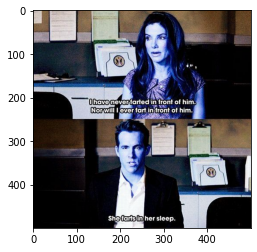

In [ ]:
# plotting the original test image

plt.imshow(cv2.imread('/content/drive/MyDrive/Computer Vision/Week_7 Assignment/Part 1Test Data - Prediction Image.jpeg',1))

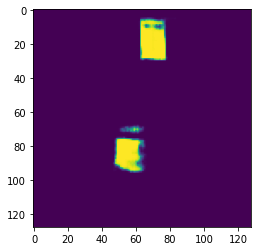

In [ ]:
# plotting the mask predicted by our network

plt.imshow(pred_img.squeeze())

**PART TWO PROJECT BASED**

•DOMAIN: Face recognition 

•CONTEXT: Company X intends to build a face identi!ication model to recognise human faces

In [ ]:
import os; 
os.chdir('/content/drive/MyDrive/Computer Vision/Week_7 Assignment')

In [ ]:
# unzipping the file

with ZipFile('Part 3 - Aligned Face Dataset from Pinterest.zip', 'r') as zip:
  zip.extractall()

In [ ]:
# creating a function to load the metadata

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [ ]:
# defining a funciton to load the image

def load_image(path):
    img2 = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img2[...,::-1]

In [ ]:
# randomly selecting an image for visualization

n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

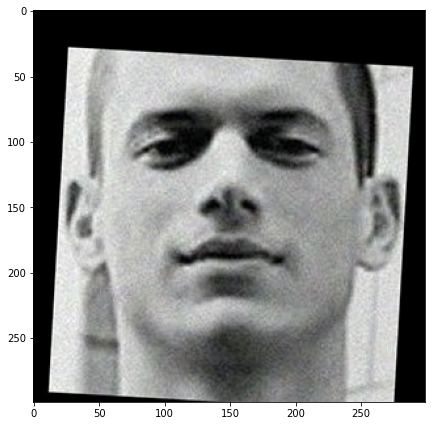

In [ ]:
# plotting the randomly selected image

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
_ = plt.imshow(img)

In [ ]:
# creating the vgg model

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
# initializing the weight of the network

vgg = vgg_face()
vgg.load_weights('Part 3 - vgg_face_weights.h5')
print(vgg.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_34 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_35 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [ ]:
# setting the input and output of the model

from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=vgg.layers[0].input, outputs=vgg.layers[-2].output)

In [ ]:
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [ ]:
# creating the embeddings for each image in the dataset

embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
  try:
    image = load_image(str(m))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

In [ ]:
# creating the distance function

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

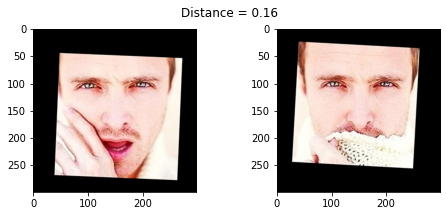

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(1, 3)

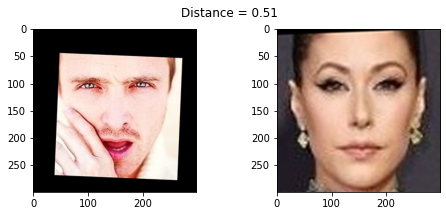

In [ ]:
show_pair(1, 180)

In [ ]:
# splitting the data into train and test dataset

train_idx = np.arange(metadata.shape[0]) % 9 != 0  
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities

X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]

In [ ]:
print("The shape of X_train is", X_train.shape)
print("The shape of X_test is",X_test.shape)
print("The shape of y_train is",y_train.shape)
print("The shape of y_test is",y_test.shape)

The shape of X_train is (9573, 2622)
The shape of X_test is (1197, 2622)
The shape of y_train is (9573,)
The shape of y_test is (1197,)


In [ ]:
# Defining the Lable Encoder and fitting on the train and test set

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
# scaling the train and test data

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
# transforming the train and test data using the pca components

pca = PCA(n_components = 128, random_state = 0)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
print("The shape of the X_train_pca is",X_train_pca.shape)
print("The shape of the X_test_pca is",X_test_pca.shape)

The shape of the X_train_pca is (9573, 128)
The shape of the X_test_pca is (1197, 128)


In [ ]:
# using gridsearch cv to find the best parameters for SVC algorithm

params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]}]

svc = GridSearchCV(SVC(random_state = 0), params_grid, cv = 3, scoring = 'f1_macro', verbose = 50, n_jobs = -1)
svc.fit(X_train_pca, y_train)

print('Best estimator found by grid search:')
print(svc.best_estimator_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best estimator found by grid search:
SVC(C=10, gamma=0.0001, random_state=0)


In [ ]:
# Fitting the best SVC model on the train data and printing the train and test accuracy

svc_pca = SVC(C = 10, gamma = 0.0001, kernel = 'rbf', class_weight = 'balanced', random_state = 0)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.999


In [ ]:
print('SVC accuracy for test set: {0:.3f}'.format(svc_pca.score(X_test_pca, y_test)))

SVC accuracy for test set: 0.959


In [ ]:
# defining a function to display and predict the test image

def predict_test(test_path):
  pred_img = cv2.imread(test_path,1)
  pred_img = pred_img[...,::-1]
  plt.imshow(pred_img)
  pred_img = (pred_img/255.).astype(np.float32)
  pred_img = cv2.resize(pred_img, (224, 224))
  pred_img = vgg_face_descriptor.predict(np.expand_dims(pred_img, axis=0))[0]

  pred_img = sc.transform(pred_img.reshape(1,-1))
  pred_img = pca.transform(pred_img)
  pred_img = svc_pca.predict(pred_img)

  pred_img = encoder.inverse_transform(pred_img)[0].split('_')[-1].title().strip()
  print("The image belongs to class", pred_img)

The image belongs to class Benedict Cumberbatch


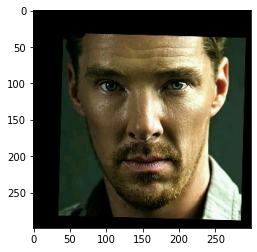

In [ ]:
predict_test("/content/drive/MyDrive/Computer Vision/Week_7 Assignment/Part 2- Test Image - Benedict Cumberbatch9.jpg")

The image belongs to class Dwayne Johnson


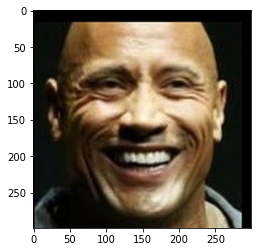

In [ ]:
predict_test("/content/drive/MyDrive/Computer Vision/Week_7 Assignment/Part 2 - Test Image - Dwayne Johnson4.jpg")